<a href="https://colab.research.google.com/github/rk101294/Car-Price-Predictor/blob/main/Sentiment_Analysis_NLP_Tute.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project: Develop an Embedding + CNN Model for Sentiment Analysis


# 1. Import all imporatant libraries

In [11]:
from nltk.corpus import stopwords 
import string 
import re 
from os import listdir 
from numpy import array 
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences 
from keras.utils.vis_utils import plot_model 
from keras.models import Sequential 
from keras.layers import Dense 
from keras.layers import Flatten 
from keras.layers import Embedding 
from keras.layers.convolutional import Conv1D 
from collections import Counter
from tensorflow.keras.layers import MaxPooling1D
from keras.models import load_model


# import nltk
# nltk.download('stopwords')

# 2. Data Preparation

This section, we will look at 3 things:
1. Separation of data into training and test sets.
2. Loading and cleaning the data to remove punctuation and numbers.
3. Deﬁning a vocabulary of preferred words

## 2.1. Loading and Cleaning Reviews
The text data is already pretty clean; not much preparation is required. Without getting bogged down too much in the details, we will prepare the data using the following way:
1. Split tokens on white space.
2. Remove all punctuation from words.
3. Remove all words that are not purely comprised of alphabetical characters.
4. Remove all words that are known stop words. 
5. Remove all words that have a length ≤ 1 character

In [2]:
# load doc into memory 
def load_doc(filename): 
  # open the file as read only 
  file = open(filename, 'r') 
  # read all text 
  text = file.read() 
  # close the file 
  file.close() 
  return text

# turn a doc into clean tokens 
def clean_doc(doc): 
  # split into tokens by white space 
  tokens = doc.split() 
  # prepare regex for char filtering 
  re_punc = re.compile('[%s]' % re.escape(string.punctuation)) 
  # remove punctuation from each word 
  tokens = [re_punc.sub('', w) for w in tokens] 
  # remove remaining tokens that are not alphabetic 
  tokens = [word for word in tokens if word.isalpha()] 
  # filter out stop words 
  stop_words = set(stopwords.words('english')) 
  tokens = [w for w in tokens if not w in stop_words] 
  # filter out short tokens 
  tokens = [word for word in tokens if len(word) > 1] 
  return tokens

# load the document 
filename = '/content/drive/MyDrive/Dataset/txt_sentoken/pos/cv000_29590.txt' 
text = load_doc(filename) 
tokens = clean_doc(text) 
print(tokens)
print(type(tokens))
print(len(tokens))


['films', 'adapted', 'comic', 'books', 'plenty', 'success', 'whether', 'theyre', 'superheroes', 'batman', 'superman', 'spawn', 'geared', 'toward', 'kids', 'casper', 'arthouse', 'crowd', 'ghost', 'world', 'theres', 'never', 'really', 'comic', 'book', 'like', 'hell', 'starters', 'created', 'alan', 'moore', 'eddie', 'campbell', 'brought', 'medium', 'whole', 'new', 'level', 'mid', 'series', 'called', 'watchmen', 'say', 'moore', 'campbell', 'thoroughly', 'researched', 'subject', 'jack', 'ripper', 'would', 'like', 'saying', 'michael', 'jackson', 'starting', 'look', 'little', 'odd', 'book', 'graphic', 'novel', 'pages', 'long', 'includes', 'nearly', 'consist', 'nothing', 'footnotes', 'words', 'dont', 'dismiss', 'film', 'source', 'get', 'past', 'whole', 'comic', 'book', 'thing', 'might', 'find', 'another', 'stumbling', 'block', 'hells', 'directors', 'albert', 'allen', 'hughes', 'getting', 'hughes', 'brothers', 'direct', 'seems', 'almost', 'ludicrous', 'casting', 'carrot', 'top', 'well', 'anythi

## Observation:
1. Running the example prints a long list of clean tokens
2. Total size is 402

## 2.2 Deﬁne a Vocabulary

It is important to deﬁne a vocabulary of known words when using a text model. The more words, the larger the representation of documents, therefore it is important to constrain the words to only those believed to be predictive.

We can develop a vocabulary as a Counter, which is a dictionary mapping of words and their count that allows us to easily update and query. Each document can be added to the counter (a new function called add doc to vocab()) and we can step over all of the reviews in the negative directory and then the positive directory (a new function called process docs()). The complete example is listed below.

In [3]:
# load doc and add to vocab 
def add_doc_to_vocab(filename, vocab): 
  # load doc 
  doc = load_doc(filename) 
  # clean doc 
  tokens = clean_doc(doc) 
  # update counts
  vocab.update(tokens)

# load all docs in a directory 
def process_docs(directory, vocab): 
  # walk through all files in the folder 
  for filename in listdir(directory): 
    # skip any reviews in the test set 
    if filename.startswith('cv9'): 
      continue 
    # create the full path of the file to open 
    path = directory + '/' + filename 
    # add doc to vocab 
    add_doc_to_vocab(path, vocab)
  
# define vocab 
vocab = Counter() 
# add all docs to vocab 
process_docs('/content/drive/MyDrive/Dataset/txt_sentoken/pos', vocab) 
process_docs('/content/drive/MyDrive/Dataset/txt_sentoken/neg', vocab) 
# print the size of the vocab 
print(len(vocab)) 
# print the top words in the vocab 
print(vocab.most_common(50))

44276
[('film', 7983), ('one', 4946), ('movie', 4826), ('like', 3201), ('even', 2262), ('good', 2080), ('time', 2041), ('story', 1907), ('films', 1873), ('would', 1844), ('much', 1824), ('also', 1757), ('characters', 1735), ('get', 1724), ('character', 1703), ('two', 1643), ('first', 1588), ('see', 1557), ('way', 1515), ('well', 1511), ('make', 1418), ('really', 1407), ('little', 1351), ('life', 1334), ('plot', 1288), ('people', 1269), ('could', 1248), ('bad', 1248), ('scene', 1241), ('movies', 1238), ('never', 1201), ('best', 1179), ('new', 1140), ('scenes', 1135), ('man', 1131), ('many', 1130), ('doesnt', 1118), ('know', 1092), ('dont', 1086), ('hes', 1024), ('great', 1014), ('another', 992), ('action', 985), ('love', 977), ('us', 967), ('go', 952), ('director', 948), ('end', 946), ('something', 945), ('still', 936)]


## Observation:

Running the example shows that we have a vocabulary of 44,276 words. We also can see a sample of the top 50 most used words in the movie reviews. Note that this vocabulary was constructed based on only those reviews in the training dataset.


In [4]:
# save list to file 
def save_list(lines, filename): 
  # convert lines to a single blob of text 
  data = '\n'.join(lines) 
  # open file 
  file = open(filename, 'w') 
  # write text 
  file.write(data) 
  # close file 
  file.close()

# keep tokens with a min occurrence 
min_occurane = 2 
tokens = [k for k,c in vocab.items() if c >= min_occurane] 
print(len(tokens)) 
# save tokens to a vocabulary file 
save_list(tokens, 'vocab.txt')

25767


## Observation:

1. Running the above example with this addition shows that the vocabulary size drops by a little more than half its size, from 44,276 to 25,767 words.

2. Running the min occurrence ﬁlter on the vocabulary and saving it to ﬁle, you should now have a new ﬁle called vocab.txt with only the words we are interested in.

# 3. Train CNN With Embedding Layer

1. A word embedding is a way of representing text where each word in the vocabulary is represented by a real valued vector in a high-dimensional space. The vectors are learned in such a way that words that have similar meanings will have similar representation in the vector space (close in the vector space).

2. The real valued vector representation for words can be learned while training the neural network. We can do this in the Keras deep learning library using the Embedding layer. The ﬁrst step is to load the vocabulary. We will use it to ﬁlter out words from movie reviews that we are not interested in. If you have worked through the previous section, you should have a local ﬁle called vocab.txt with one word per line. We can load that ﬁle and build a vocabulary as a set for checking the validity of tokens.

## NOTE:

1. The next step is to encode each document as a sequence of integers. The Keras Embedding layer requires integer inputs where each integer maps to a single token that has a speciﬁc real-valued vector representation within the embedding. These vectors are random at the beginning of training, but during training become meaningful to the network. We can encode the training documents as sequences of integers using the Tokenizer class in the Keras API. First, we must construct an instance of the class then train it on all documents in the training dataset. In this case, it develops a vocabulary of all tokens in the training dataset and develops a consistent mapping from words in the vocabulary to unique integers. We could just as easily develop this mapping ourselves using our vocabulary ﬁle.

2. We also need to ensure that all documents have the same length. This is a requirement of Keras for eﬃcient computation. We could truncate reviews to the smallest size or zero-pad (pad with the value 0) reviews to the maximum length, or some hybrid. In this case, we will pad all reviews to the length of the longest review in the training dataset. First, we can ﬁnd the longest review using the max() function on the training dataset and take its length. We can then call the Keras function pad sequences() to pad the sequences to the maximum length by adding 0 values on the end.

In [5]:
# load doc into memory 
def load_doc(filename): 
  # open the file as read only 
  file = open(filename, 'r') 
  # read all text 
  text = file.read() 
  # close the file 
  file.close() 
  return text

# turn a doc into clean tokens 
def clean_doc(doc, vocab): 
  # split into tokens by white space 
  tokens = doc.split() 
  # prepare regex for char filtering 
  re_punc = re.compile('[%s]' % re.escape(string.punctuation)) 
  # remove punctuation from each word 
  tokens = [re_punc.sub('', w) for w in tokens] 
  # filter out tokens not in vocab 
  tokens = [w for w in tokens if w in vocab] 
  tokens = ' '.join(tokens) 
  return tokens

# load all docs in a directory 
def process_docs(directory, vocab, is_train): 
  documents = list() 
  # walk through all files in the folder 
  for filename in listdir(directory): 
    # skip any reviews in the test set 
    if is_train and filename.startswith('cv9'): 
      continue 
    if not is_train and not filename.startswith('cv9'): 
      continue 
    # create the full path of the file to open 
    path = directory + '/' + filename 
    # load the doc 
    doc = load_doc(path)
    # clean doc 
    tokens = clean_doc(doc, vocab) 
    # add to list 
    documents.append(tokens) 
  return documents

In [6]:
# load and clean a dataset 
def load_clean_dataset(vocab, is_train): 
  # load documents 
  neg = process_docs('/content/drive/MyDrive/Dataset/txt_sentoken/neg', vocab, is_train) 
  pos = process_docs('/content/drive/MyDrive/Dataset/txt_sentoken/pos', vocab, is_train) 
  docs = neg + pos 
  # prepare labels 
  labels = array([0 for _ in range(len(neg))] + [1 for _ in range(len(pos))]) 
  return docs, labels


In [7]:
# fit a tokenizer 
def create_tokenizer(lines): 
  tokenizer = Tokenizer() 
  tokenizer.fit_on_texts(lines) 
  return tokenizer

# integer encode and pad documents 
def encode_docs(tokenizer, max_length, docs): 
  # integer encode 
  encoded = tokenizer.texts_to_sequences(docs) 
  # pad sequences 
  padded = pad_sequences(encoded, maxlen=max_length, padding='post') 
  return padded


## NOTE: 

We will use a 100-dimensional vector space, but you could try other values, such as 50 or 150. Finally, the maximum document length was calculated above in the max length variable used during padding. The complete model deﬁnition is listed below including the Embedding layer. We use a Convolutional Neural Network (CNN) as they have proven to be successful at document classiﬁcation problems. A conservative CNN conﬁguration is used with 32 ﬁlters (parallel ﬁelds for processing words) and a kernel size of 8 with a rectiﬁed linear (relu) activation function. This is followed by a pooling layer that reduces the output of the convolutional layer by half. Next, the 2D output from the CNN part of the model is ﬂattened to one long 2D vector to represent the features extracted by the CNN. The back-end of the model is a standard Multilayer Perceptron layers to interpret the CNN features. The output layer uses a sigmoid activation function to output a value between 0 and 1 for the negative and positive sentiment in the review.

In [8]:
# define the model 
def define_model(vocab_size, max_length): 
  model = Sequential() 
  model.add(Embedding(vocab_size, 100, input_length=max_length)) 
  model.add(Conv1D(filters=32, kernel_size=4, activation='relu')) 
  model.add(MaxPooling1D(pool_size=2)) 
  model.add(Flatten()) 
  model.add(Dense(10, activation='relu')) 
  model.add(Dense(1, activation='sigmoid')) 
  # compile network 
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) 
  # summarize defined model 
  model.summary() 
  plot_model(model, to_file='model.png', show_shapes=True) 
  return model


In [9]:


# load the vocabulary 
vocab_filename = 'vocab.txt' 
vocab = load_doc(vocab_filename) 
vocab = set(vocab.split()) 
# load training data 
train_docs, ytrain = load_clean_dataset(vocab, True) 
# create the tokenizer 
tokenizer = create_tokenizer(train_docs) 
# define vocabulary size 
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary size: %d' % vocab_size) 

# calculate the maximum sequence length 
max_length = max([len(s.split()) for s in train_docs]) 
print('Maximum length: %d' % max_length) 
# encode data 
Xtrain = encode_docs(tokenizer, max_length, train_docs) 
# define model 
model = define_model(vocab_size, max_length) 

# fit network 
# Next, we ﬁt the network on the training data. 
# We use a binary cross entropy loss function because the problem we are learning is a binary classiﬁcation problem
model.fit(Xtrain, ytrain, epochs=10, verbose=2) 
# save the model 
model.save('model.h5')

Vocabulary size: 25768
Maximum length: 1317
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1317, 100)         2576800   
_________________________________________________________________
conv1d (Conv1D)              (None, 1314, 32)          12832     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 657, 32)           0         
_________________________________________________________________
flatten (Flatten)            (None, 21024)             0         
_________________________________________________________________
dense (Dense)                (None, 10)                210250    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 2,799,893
Trainable params: 2,799,893
Non-trainable params: 0
__

## Observation:

1. We can see that the Embedding layer expects documents with a length of 1,317 words as input and encodes each word in the document as a 100 element vector.

2. Running the example will ﬁrst provide a summary of the training dataset vocabulary (25,768) and maximum input sequence length in words (1,317)

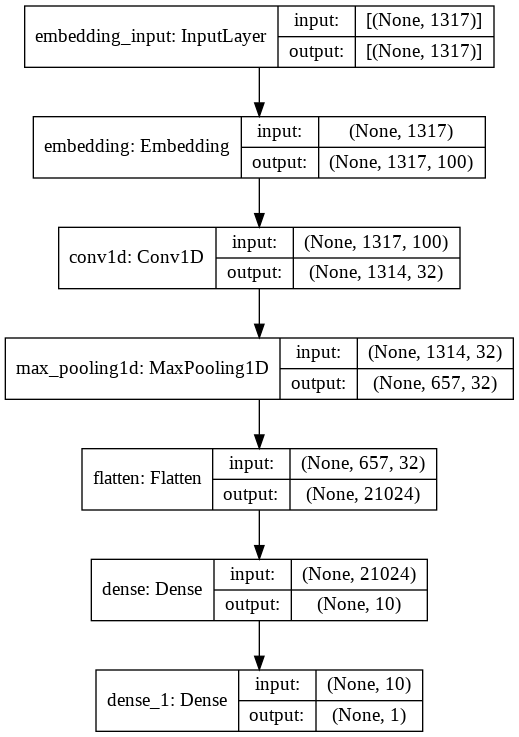

In [18]:
plot_model(model, to_file='model.png', show_shapes=True)


# Evaluate Model


In [12]:
# load doc into memory 
def load_doc(filename): 
  # open the file as read only 
  file = open(filename, 'r') 
  # read all text 
  text = file.read() 
  # close the file 
  file.close() 
  return text

# turn a doc into clean tokens 
def clean_doc(doc, vocab): 
  # split into tokens by white space 
  tokens = doc.split() 
  # prepare regex for char filtering 
  re_punc = re.compile('[%s]' % re.escape(string.punctuation)) 
  # remove punctuation from each word 
  tokens = [re_punc.sub('', w) for w in tokens] 
  # filter out tokens not in vocab 
  tokens = [w for w in tokens if w in vocab] 
  tokens = ' '.join(tokens) 
  return tokens



In [13]:
# load all docs in a directory 
def process_docs(directory, vocab, is_train): 
  documents = list() 
  # walk through all files in the folder 
  for filename in listdir(directory): 
    # skip any reviews in the test set 
    if is_train and filename.startswith('cv9'): 
      continue 
    if not is_train and not filename.startswith('cv9'): 
      continue 
    # create the full path of the file to open 
    path = directory + '/' + filename 
    # load the doc
    doc = load_doc(path) 
    # clean doc 
    tokens = clean_doc(doc, vocab) 
    # add to list 
    documents.append(tokens) 
  return documents

# load and clean a dataset 
def load_clean_dataset(vocab, is_train): 
  # load documents 
  neg = process_docs('/content/drive/MyDrive/Dataset/txt_sentoken/neg', vocab, is_train) 
  pos = process_docs('/content/drive/MyDrive/Dataset/txt_sentoken/pos', vocab, is_train) 
  docs = neg + pos 
  # prepare labels 
  labels = array([0 for _ in range(len(neg))] + [1 for _ in range(len(pos))]) 
  return docs, labels



In [14]:
# fit a tokenizer 
def create_tokenizer(lines): 
  tokenizer = Tokenizer() 
  tokenizer.fit_on_texts(lines) 
  return tokenizer

# integer encode and pad documents 
def encode_docs(tokenizer, max_length, docs): 
  # integer encode 
  encoded = tokenizer.texts_to_sequences(docs) 
  # pad sequences 
  padded = pad_sequences(encoded, maxlen=max_length, padding='post') 
  return padded

# classify a review as negative or positive 
def predict_sentiment(review, vocab, tokenizer, max_length, model): 
  # clean review 
  line = clean_doc(review, vocab) 
  # encode and pad review 
  padded = encode_docs(tokenizer, max_length, [line]) 
  # predict sentiment 
  yhat = model.predict(padded, verbose=0) 
  # retrieve predicted percentage and label 
  percent_pos = yhat[0,0] 
  if round(percent_pos) == 0: 
    return (1-percent_pos), 'NEGATIVE' 
  return percent_pos, 'POSITIVE'




In [15]:
# load the vocabulary 
vocab_filename = 'vocab.txt' 
vocab = load_doc(vocab_filename) 
vocab = set(vocab.split()) 
# load all reviews 
train_docs, ytrain = load_clean_dataset(vocab, True) 
test_docs, ytest = load_clean_dataset(vocab, False) 
# create the tokenizer 
tokenizer = create_tokenizer(train_docs) 
# define vocabulary size 
vocab_size = len(tokenizer.word_index) + 1 
print('Vocabulary size: %d' % vocab_size) 
# calculate the maximum sequence length 
max_length = max([len(s.split()) for s in train_docs]) 
print('Maximum length: %d' % max_length) 
# encode data 
Xtrain = encode_docs(tokenizer, max_length, train_docs) 
Xtest = encode_docs(tokenizer, max_length, test_docs) 
# load the model 
model = load_model('model.h5') 
# evaluate model on training dataset 
_, acc = model.evaluate(Xtrain, ytrain, verbose=0) 
print('Train Accuracy: %.2f' % (acc*100)) 
# evaluate model on test dataset 
_, acc = model.evaluate(Xtest, ytest, verbose=0) 
print('Test Accuracy: %.2f' % (acc*100))

Vocabulary size: 25768
Maximum length: 1317
Train Accuracy: 100.00
Test Accuracy: 89.00


In [16]:
# test positive text
text = 'Everyone will enjoy this film. I love it, recommended!' 
percent, sentiment = predict_sentiment(text, vocab, tokenizer, max_length, model) 
print('Review: [%s]\nSentiment: %s (%.3f%%)' % (text, sentiment, percent*100)) 

# test negative text 
text = 'This is a bad movie. Do not watch it. It sucks.' 
percent, sentiment = predict_sentiment(text, vocab, tokenizer, max_length, model) 
print('Review: [%s]\nSentiment: %s (%.3f%%)' % (text, sentiment, percent*100))

Review: [Everyone will enjoy this film. I love it, recommended!]
Sentiment: POSITIVE (54.285%)
Review: [This is a bad movie. Do not watch it. It sucks.]
Sentiment: NEGATIVE (60.738%)


## Observation:

Running the example ﬁrst prints the skill of the model on the training and test dataset. We can see that the model achieves 100% accuracy on the training dataset and 89.00% on the test dataset, an impressive score. Next, we can see that the model makes the correct prediction on two contrived movie reviews. We can see that the percentage or conﬁdence of the prediction is close to 50% for both, this may be because the two contrived reviews are very short and the model is expecting sequences of 1,000 or more words.


# *** Extensions ***

This section lists some ideas for extending the tutorial that you may wish to explore.

1. **Data Cleaning**: Explore better data cleaning, perhaps leaving some punctuation in tact or normalizing contractions.

2. **Truncated Sequences**: Padding all sequences to the length of the longest sequence might be extreme if the longest sequence is very diﬀerent to all other reviews. Study the distribution of review lengths and truncate reviews to a mean length.

3. **Truncated Vocabulary**: We removed infrequently occurring words, but still had a large vocabulary of more than 25,000 words. Explore further reducing the size of the vocabulary and the eﬀect on model skill.

4. **Filters and Kernel Size**: The number of ﬁlters and kernel size are important to model skill and were not tuned. Explore tuning these two CNN parameters.

5. **Epochs and Batch Size**: The model appears to ﬁt the training dataset quickly. Explore alternate conﬁgurations of the number of training epochs and batch size and use the test dataset as a validation set to pick a better stopping point for training the model.

6.  **Deeper Network**: Explore whether a deeper network results in better skill, either in terms of CNN layers, MLP layers and both.

7. **Pre-Train an Embedding**: Explore pre-training a Word2Vec word embedding in the model and the impact on model skill with and without further ﬁne tuning during training.

8. **Use GloVe Embedding**: Explore loading the pre-trained GloVe embedding and the impact on model skill with and without further ﬁne tuning during training.

9. **Longer Test Reviews**: Explore whether the skill of model predictions is dependent on the length of movie reviews as suspected in the ﬁnal section on evaluating the model.

10. **Train Final Model**: Train a ﬁnal model on all available data and use it make predictions on real ad hoc movie reviews from the internet.
